# **2023 NFL Big Data Bowl EDA**
### Sol Ben-Ishay

## **Extract+Clean the Data**

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
from datetime import datetime

In [2]:
# Read in data
games_df = pd.read_csv("../Data/games.csv")
plays_df = pd.read_csv("../Data/plays.csv")
players_df = pd.read_csv("../Data/players.csv")
scouting_df = pd.read_csv("../Data/pffScoutingData.csv")
tracking_df_list = ["../Data/tracking/week1.csv", "../Data/tracking/week2.csv", "../Data/tracking/week3.csv", "../Data/tracking/week4.csv",
"../Data/tracking/week5.csv", "../Data/tracking/week6.csv", "../Data/tracking/week7.csv", "../Data/tracking/week8.csv"]
tracking_df = pd.concat(map(pd.read_csv, tracking_df_list))

In [3]:
#Get the main frame-level tracking df
coi = ['gameId', 'season', 'week', 'playId',
       'playDescription',  'frameId', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'defensiveTeam', 'passResult', 'prePenaltyPlayResult',
       'absoluteYardlineNumber', 'yardlineSide','yardlineNumber', 'dropBackType',
       'pff_playAction', 'nflId', 'time', 'team', 'x', 'y', 'o', 'event', 'officialPosition',
       'displayName','pff_role','pff_positionLinedUp', 'pff_hit', 'pff_hurry', 'pff_sack']

frame_df = (games_df.merge(plays_df, on='gameId', how='left')
                .merge(tracking_df, on=['gameId','playId'], how='left')
                .merge(players_df, on= 'nflId', how='left')
                .merge(scouting_df, on=['gameId','playId','nflId']))[coi]

frame_df = frame_df.rename(columns={'defensiveTeam':'defTeam', 'possessionTeam':'offTeam', 'pff_playAction':'playAction',
'officialPosition':'position', 'displayName':'playerName', 'pff_role':'roleOnPlay', 'pff_positionLinedUp':'posLinedUp'})

# Convert up dt_time column to time
frame_df['time'] = pd.to_datetime(frame_df['time'])

# Replace n/a dropBackType and yardlineSide
frame_df = frame_df.fillna(value={'dropBackType': 'none', 'yardlineSide': 'middle'})

# Replace missing n/a absoluteYardlineNumber for a specific play (not sure why)
missing_abs_yd_rows = frame_df.query("absoluteYardlineNumber.isna()").index.to_list()
frame_df.loc[missing_abs_yd_rows,'absoluteYardlineNumber'] = 71.0

frame_df.head()

,gameId,season,week,playId,playDescription,frameId,quarter,down,yardsToGo,offTeam,...,y,o,event,position,playerName,roleOnPlay,posLinedUp,pff_hit,pff_hurry,pff_sack
0,2021090900,2021,1,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,1,3,2,TB,...,24.22,165.16,None,QB,Tom Brady,Pass,QB,NaN,NaN,NaN
1,2021090900,2021,1,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,2,1,3,2,TB,...,24.22,164.33,None,QB,Tom Brady,Pass,QB,NaN,NaN,NaN
2,2021090900,2021,1,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,3,1,3,2,TB,...,24.24,160.24,None,QB,Tom Brady,Pass,QB,NaN,NaN,NaN
3,2021090900,2021,1,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,4,1,3,2,TB,...,24.25,152.13,None,QB,Tom Brady,Pass,QB,NaN,NaN,NaN
4,2021090900,2021,1,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,5,1,3,2,TB,...,24.26,148.33,None,QB,Tom Brady,Pass,QB,NaN,NaN,NaN


In [4]:
# Query maker
coi = ['gameId', 'season', 'quarter', 'week', 'playId',
       'playDescription', 'yardsToGo', 'offTeam', 'defTeam',
       'absoluteYardlineNumber', 'yardlineSide','yardlineNumber']
pd.set_option('display.max_colwidth', None)
frame_df.query("absoluteYardlineNumber.isna()")[coi].drop_duplicates()

,gameId,season,quarter,week,playId,playDescription,yardsToGo,offTeam,defTeam,absoluteYardlineNumber,yardlineSide,yardlineNumber


In [5]:
# Check for na data
if sum(frame_df.isna().sum().values) != 0:
    print(frame_df.isna().sum().loc[lambda x: x > 0])

pff_hit      3976346
pff_hurry    3976346
pff_sack     3976346
dtype: int64


In [6]:
# Exploratory checks for unique values for different columns
frame_df['event'].unique()
# Potential snap events: ['ball_snap', 'autoevent_ballsnap']
# Potential action events: ['pass_forward', 'autoevent_passforward', 'qb_sack', 'fumble', 'run', 'qb_strip_sack', 'lateral', 'handoff', 'tackle']
# Potential drop back types: ['TRADITIONAL', 'SCRAMBLE_ROLLOUT_RIGHT', 'DESIGNED_ROLLOUT_RIGHT', 'nan', 'SCRAMBLE', 'DESIGNED_ROLLOUT_LEFT', 'UNKNOWN', 'DESIGNED_RUN', 'SCRAMBLE_ROLLOUT_LEFT']

array(['None', 'ball_snap', 'autoevent_passforward', 'pass_forward',
       'autoevent_ballsnap', 'line_set', 'play_action', 'pass_arrived',
       'autoevent_passinterrupted', 'fumble', 'fumble_offense_recovered',
       'qb_sack', 'run', 'man_in_motion', 'pass_outcome_caught',
       'pass_outcome_incomplete', 'pass_tipped', 'qb_strip_sack', 'shift',
       'first_contact', 'huddle_break_offense', 'lateral', 'handoff',
       'penalty_flag', 'tackle', 'dropped_pass', 'out_of_bounds'],
      dtype=object)

In [7]:
# Get the player-level general stats df (by selecting the first frame from each play)
coi = ['gameId', 'season', 'week', 'playId', 'nflId', 'offTeam', 'defTeam', 'quarter', 'down', 'yardsToGo', 'passResult', 'prePenaltyPlayResult', 'playerName', 'position', 'roleOnPlay', 'pff_hit', 'pff_hurry', 'pff_sack']
player_gen_stat_df = frame_df.query("frameId == 1")[coi]
player_gen_stat_df.head()

,gameId,season,week,playId,nflId,offTeam,defTeam,quarter,down,yardsToGo,passResult,prePenaltyPlayResult,playerName,position,roleOnPlay,pff_hit,pff_hurry,pff_sack
0,2021090900,2021,1,97,25511.0,TB,DAL,1,3,2,I,0,Tom Brady,QB,Pass,NaN,NaN,NaN
43,2021090900,2021,1,97,35481.0,TB,DAL,1,3,2,I,0,Rob Gronkowski,TE,Pass Route,NaN,NaN,NaN
86,2021090900,2021,1,97,35634.0,TB,DAL,1,3,2,I,0,Antonio Brown,WR,Pass Route,NaN,NaN,NaN
129,2021090900,2021,1,97,39985.0,TB,DAL,1,3,2,I,0,Giovani Bernard,RB,Pass Route,NaN,NaN,NaN
172,2021090900,2021,1,97,40151.0,TB,DAL,1,3,2,I,0,Ryan Jensen,C,Pass Block,NaN,NaN,NaN


In [8]:
# Get the play-level general stats df (by selecting the first frame and arbitrarily the QB on each play)
play_gen_stat_df = frame_df.query("(roleOnPlay == 'Pass') and (position == 'QB') and (frameId == 1)")[coi]
play_gen_stat_df.head()

,gameId,season,week,playId,nflId,offTeam,defTeam,quarter,down,yardsToGo,passResult,prePenaltyPlayResult,playerName,position,roleOnPlay,pff_hit,pff_hurry,pff_sack
0,2021090900,2021,1,97,25511.0,TB,DAL,1,3,2,I,0,Tom Brady,QB,Pass,NaN,NaN,NaN
1279,2021090900,2021,1,137,43424.0,DAL,TB,1,1,10,C,28,Dak Prescott,QB,Pass,NaN,NaN,NaN
1977,2021090900,2021,1,187,43424.0,DAL,TB,1,2,6,C,5,Dak Prescott,QB,Pass,NaN,NaN,NaN
2829,2021090900,2021,1,282,43424.0,DAL,TB,1,1,10,I,0,Dak Prescott,QB,Pass,NaN,NaN,NaN
3684,2021090900,2021,1,349,43424.0,DAL,TB,1,3,15,I,0,Dak Prescott,QB,Pass,NaN,NaN,NaN


## **Feature Engineering**

### **Snap to Action Time**

*Get the time from snap to an action event for each play for further analysis with individual OL/DL and Off/Def lines*

An action event is defined as the earliest of the following:  
  - A throw  
  - A non-throw, but play-ending event (QB sack, strip sack)
  - Any play where the QB doesn't scramble  
  - NOT YET: 3.5 seconds post-snap

A hard time cap is useful for reducing noise introduced by “broken” plays. Plays without a targeted receiver are not used for training, but are included for predictions so that players can be quantified on all pass plays.

In [9]:
# Get time from snap to action event for each play
potential_snap_events = ['ball_snap', 'autoevent_ballsnap']
potential_action_events = ['pass_forward', 'autoevent_passforward', 'qb_sack', 'fumble', 'run', 'qb_strip_sack', 'lateral', 'handoff', 'tackle']
potential_pass_results = ['I', 'C', 'S', 'R', 'IN']

# Get the time of all the key events for each play (all individual snap/action event)
conds = f"((event in {potential_snap_events}) or (event in {potential_action_events})) and (passResult in {potential_pass_results})"
coi = ['gameId', 'playId', 'event', 'time']
snap_to_action_df = frame_df.query(conds)[coi]

# Get the time of the snap/action events of interests for each play
# Note: Not distinguishing snap/action times based on if they're from auto/manual events
# Utilizing the times of the earliest snap and earliest action event to calculate the snap to action time.
snap_to_action_df.loc[snap_to_action_df['event'].isin(potential_snap_events),'event'] = "ballsnap"
snap_to_action_df.loc[snap_to_action_df['event'].isin(potential_action_events),'event'] = "action"
snap_to_action_df = snap_to_action_df.groupby(['gameId','playId','event']).min().reset_index().sort_values(by=['time'])

# Drop rows where the tracking data is missing either a snap/action event
bad_rows = (snap_to_action_df[['gameId','playId','event']]
            .groupby(['gameId','playId']).count().query('event != 2')
            .reset_index().drop(columns=['event']))
outer = snap_to_action_df.merge(bad_rows, on=['gameId','playId'], how='outer', indicator=True)
snap_to_action_df = outer[outer._merge == 'left_only'].drop(columns=['_merge'])

# Get the snap to action event time for each play
coi = ['gameId', 'playId', 'time']
snap_to_action_df = snap_to_action_df[coi].groupby(['gameId', 'playId']).agg(lambda x: np.max(x) - np.min(x)).reset_index().rename(columns={'time':'snap_to_action_time'})
snap_to_action_df['snap_to_action_time'] = snap_to_action_df['snap_to_action_time'].apply(lambda x: x.total_seconds())
snap_to_action_df = snap_to_action_df.sort_values(by=['snap_to_action_time']).reset_index(drop=True)
snap_to_action_df.head()

,gameId,playId,snap_to_action_time
0,2021100307,2997,0.5
1,2021100304,293,0.5
2,2021103105,2596,0.7
3,2021101707,2181,0.7
4,2021092610,2033,0.8


### **Rushers' Distance from QB at Release**

*Get the straight-line distance of each of the rushers from the QB at the time of release/action event for each play for further analysis with individual OL/DL and Off/Def lines*

In [10]:
# 1. Get the time of the QB release on each play
coi = ['gameId', 'playId', 'frameId']
potential_action_events = ['pass_forward', 'autoevent_passforward', 'qb_sack', 'fumble', 'run', 'qb_strip_sack', 'lateral', 'handoff', 'tackle']
potential_play_results = ['I', 'C', 'S', 'R', 'IN']
conds = f"position == 'QB' and event in {potential_action_events} and passResult in {potential_play_results}"
release_frame_df = frame_df.query(conds)[coi].groupby(['gameId', 'playId']).min().reset_index()

# 2. Get the position of the QB at release on each play
coi = ['gameId', 'playId', 'frameId', 'x', 'y']
conds = "position == 'QB'"
qb_pos_df = frame_df.query(conds)[coi]
qb_pos_at_rel_df = release_frame_df.merge(qb_pos_df, how='left', on=['gameId', 'playId', 'frameId']).rename(columns={"x":"qb_x_at_rel","y":"qb_y_at_rel"})
qb_pos_at_rel_df = qb_pos_at_rel_df.drop(columns=['frameId'])
qb_pos_at_rel_df.head()

# 3. Get the position of the "pass rushers" at release on each play
coi = ['gameId', 'playId', 'frameId', 'nflId', 'x', 'y']
conds = "roleOnPlay == 'Pass Rush'"
rusher_pos_df = frame_df.query(conds)[coi]
rusher_pos_at_rel_df = release_frame_df.merge(rusher_pos_df, how='left', on=['gameId', 'playId', 'frameId']).rename(columns={"x":"x_at_rel","y":"y_at_rel"})
rusher_pos_at_rel_df = rusher_pos_at_rel_df.drop(columns=['frameId'])
rusher_pos_at_rel_df.head()

# 4. Get the rusher distance from qb at release df
rusher_pos_at_rel_df = rusher_pos_at_rel_df.merge(qb_pos_at_rel_df, how='left', on=['gameId','playId'])
rusher_pos_at_rel_df['x2-x1'] = (rusher_pos_at_rel_df['qb_x_at_rel'] - rusher_pos_at_rel_df['x_at_rel'])**2
rusher_pos_at_rel_df['y2-y1'] = (rusher_pos_at_rel_df['qb_y_at_rel'] - rusher_pos_at_rel_df['y_at_rel'])**2
rusher_pos_at_rel_df['distance_at_rel'] = np.sqrt(rusher_pos_at_rel_df['x2-x1'] + rusher_pos_at_rel_df['y2-y1'])
rusher_dist_at_rel_df = rusher_pos_at_rel_df[['gameId','playId','nflId','distance_at_rel']]
rusher_dist_at_rel_df.head()

,gameId,playId,nflId,distance_at_rel
0,2021090900,97,41263.0,3.238673
1,2021090900,97,42403.0,3.805391
2,2021090900,97,44955.0,10.437672
3,2021090900,97,53441.0,2.308679
4,2021090900,97,53504.0,2.496498


## **Offensive Line Analysis**

### Team

In [11]:
# Get the play-level OL relevant data only for plays with QBs who played more than 30 snaps (to account for outlying events such as when a typical starter is injured)
high_snap_qbs = play_gen_stat_df.nflId.value_counts().loc[lambda c: c > 30].index.tolist()

coi = ['gameId', 'playId', 'offTeam', 'passResult', 'prePenaltyPlayResult']
ol_df = play_gen_stat_df.query(f"nflId in {high_snap_qbs}")[coi]

ol_df = ol_df.merge(snap_to_action_df, on=['gameId', 'playId'], how = 'left')

ol_df.head()

,gameId,playId,offTeam,passResult,prePenaltyPlayResult,snap_to_action_time
0,2021090900,97,TB,I,0,3.2
1,2021090900,137,DAL,C,28,2.6
2,2021090900,187,DAL,C,5,2.0
3,2021090900,282,DAL,I,0,3.2
4,2021090900,349,DAL,I,0,2.6


#### Exploratory Plots

In [12]:
# Two-way descriptive statistics
pass_res_des_stats = ol_df[["passResult", "prePenaltyPlayResult", "snap_to_action_time"]].groupby("passResult")[["snap_to_action_time", "prePenaltyPlayResult"]].describe()
pass_res_des_stats

snap_to_action_time                                              \
                         count      mean       std  min    25%  50%    75%   
passResult                                                                   
C                       4536.0  2.802866  1.022007  0.5  2.200  2.6  3.200   
I                       2685.0  3.190317  1.300717  0.5  2.400  2.9  3.600   
IN                       181.0  3.308287  1.110349  0.7  2.600  3.1  3.600   
R                        436.0  4.329817  1.218735  1.6  3.475  4.2  4.925   
S                        532.0  4.424436  1.220017  1.0  3.600  4.3  5.000   

                 prePenaltyPlayResult                                       \
             max                count      mean        std   min  25%  50%   
passResult                                                                   
C           17.1               4551.0  12.13096  10.378888  -8.0  6.0  9.0   
I           19.2               2689.0   0.00000   0.000000   0.0  0.0  0.0   
IN           7.3                182.0   0.00000   0.000000   0.0  0.0  0.0   
R            8.7                438.0   7.73516   6.130406   1.0  4.0  6.0   
S            9.6                533.0  -7.04878   3.834139 -34.0 -9.0 -7.0   

                        
             75%   max  
passResult              
C           15.0  91.0  
I            0.0   0.0  
IN           0.0   0.0  
R           10.0  39.0  
S           -5.0   0.0

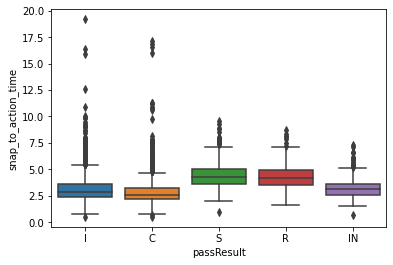

In [13]:
# Boxplot of the snap to action time vs pass result
box = sns.boxplot(data=ol_df, x="passResult", y="snap_to_action_time")
plt.show()

### Individual

#### Quarterbacks

In [14]:
# Average snap to action times per quarterback (for QBs who played more than 30 snaps)
high_snap_qbs = play_gen_stat_df.nflId.value_counts().loc[lambda c: c > 30].index.tolist()

coi = ['gameId', 'playId', 'playerName', 'passResult', 'prePenaltyPlayResult']
qb_df = play_gen_stat_df.query(f"nflId in {high_snap_qbs}")[coi]

qb_df = qb_df.merge(snap_to_action_df, on=['gameId', 'playId'], how = 'left')

qb_avg_snap_to_action_df = qb_df[["playerName","snap_to_action_time"]].groupby("playerName").mean().sort_values(by=['snap_to_action_time'],ascending=[True]).reset_index()
qb_avg_snap_to_action_df.head()

,playerName,snap_to_action_time
0,Ben Roethlisberger,2.661765
1,Mike White,2.697368
2,Tom Brady,2.787908
3,Cooper Rush,2.793478
4,Mac Jones,2.820641


In [15]:
# Pass result counts by QB
qb_pass_results = (qb_df[["playerName", "passResult"]]
                    .groupby(["playerName","passResult"])
                    .value_counts().reset_index(name="count").sort_values(by=["passResult", "count"], ascending=[True, False]))
qb_pass_results.head()

,playerName,passResult,count
74,Jared Goff,C,189
168,Tom Brady,C,179
124,Matt Ryan,C,176
119,Mac Jones,C,170
138,Patrick Mahomes,C,167


## **Defensive Line Analysis**

### Individual

In [16]:
# Get the player-level DL relevant data for players who played more than 30 snaps (to account for noise)
high_snap_pass_rushers = player_gen_stat_df.query("position in ['DE','DT','NT','OLB']").nflId.value_counts().loc[lambda c: c > 30].index.tolist()

coi = ['gameId', 'playId', 'nflId', 'season', 'week',
    'offTeam', 'defTeam', 'quarter', 'down', 'yardsToGo', 'passResult',
    'prePenaltyPlayResult', 'playerName', 'position', 'snap_to_action_time',
    'distance_at_rel', 'pff_hit', 'pff_hurry', 'pff_sack']
dl_df = (player_gen_stat_df.query(f"nflId in {high_snap_pass_rushers}")
        .merge(rusher_dist_at_rel_df, how='left', on=['gameId','playId','nflId'])
        .merge(snap_to_action_df, how='left', on=['gameId','playId'])[coi])

dl_df.head()

,gameId,playId,nflId,season,week,offTeam,defTeam,quarter,down,yardsToGo,passResult,prePenaltyPlayResult,playerName,position,snap_to_action_time,distance_at_rel,pff_hit,pff_hurry,pff_sack
0,2021090900,97,42403.0,2021,1,TB,DAL,1,3,2,I,0,Randy Gregory,DE,3.2,3.805391,0.0,1.0,0.0
1,2021090900,97,44955.0,2021,1,TB,DAL,1,3,2,I,0,Carlos Watkins,DE,3.2,10.437672,0.0,0.0,0.0
2,2021090900,97,53441.0,2021,1,TB,DAL,1,3,2,I,0,Micah Parsons,OLB,3.2,2.308679,0.0,1.0,0.0
3,2021090900,97,53504.0,2021,1,TB,DAL,1,3,2,I,0,Osa Odighizuwa,DT,3.2,2.496498,0.0,1.0,0.0
4,2021090900,137,35441.0,2021,1,DAL,TB,1,1,10,C,28,Ndamukong Suh,DE,2.6,3.635505,0.0,0.0,0.0


In [17]:
# Look at some player level average statistics
coi = ['playerName', 'nflId', 'position', 'snap_to_action_time',
    'distance_at_rel', 'pff_hit', 'pff_hurry', 'pff_sack']
indy_dl_stats_df = dl_df[coi].groupby(['playerName','nflId','position']).mean()
indy_dl_stats_df = indy_dl_stats_df.sort_values(by=['pff_sack'],ascending=[False]).reset_index()

indy_dl_stats_df.head(20)

,playerName,nflId,position,snap_to_action_time,distance_at_rel,pff_hit,pff_hurry,pff_sack
0,Jonathan Greenard,52498.0,DE,3.171429,4.409079,0.035294,0.047059,0.082353
1,Myles Garrett,44813.0,DE,3.083886,4.482110,0.042654,0.137441,0.056872
2,Jacob Tuioti-Mariner,46416.0,OLB,3.700000,4.407212,0.000000,0.051282,0.051282
3,Matt Judon,43435.0,OLB,3.245935,5.409837,0.028455,0.109756,0.048780
4,T.J. Watt,44842.0,OLB,2.930178,4.504195,0.035503,0.053254,0.047337
5,Kemoko Turay,46121.0,DE,3.366667,4.522927,0.028986,0.043478,0.043478
6,Olasunkanmi Adeniyi,46457.0,OLB,3.246667,4.665342,0.053763,0.032258,0.043011
7,Michael Pierce,43694.0,NT,3.367391,6.631365,0.000000,0.085106,0.042553
8,Trey Hendrickson,44915.0,DE,3.184034,4.567773,0.025210,0.121849,0.042017
9,Nick Bosa,47785.0,DE,3.078363,4.972445,0.052632,0.087719,0.040936
